In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

from sklearn import model_selection
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
import optuna

from joblib import Parallel, delayed

warnings.filterwarnings('ignore')

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Read Train data

In [2]:
train_home_team_statistics_df = pd.read_csv('./Train_Data/train_home_team_statistics_df.csv', index_col=0)
train_away_team_statistics_df = pd.read_csv('./Train_Data/train_away_team_statistics_df.csv', index_col=0)

train_home_player_statistics_df = pd.read_csv('./Train_Data/train_home_player_statistics_df.csv', index_col=0)
train_away_player_statistics_df = pd.read_csv('./Train_Data/train_away_player_statistics_df.csv', index_col=0)

train_scores = pd.read_csv('./Y_train.csv', index_col=0)

## Data Cleaning

In [3]:
def clean_nan_zero_columns(df, threshold):
    df = df.replace({np.inf: np.nan, -np.inf: np.nan})
    nan_ratio = df.isna().mean()
    zero_ratio = (df == 0.0).mean()
    combined_ratio = nan_ratio + zero_ratio

    columns_to_drop = combined_ratio[combined_ratio > threshold].index
    df_cleaned = df.drop(columns=columns_to_drop)
    return df_cleaned

In [4]:
train_home = train_home_team_statistics_df.iloc[:,2:]
train_away = train_away_team_statistics_df.iloc[:,2:]

train_home_player = train_home_player_statistics_df.iloc[:,2:]
train_away_player = train_away_player_statistics_df.iloc[:,2:]

# train_home.columns = 'HOME_' + train_home.columns
# train_away.columns = 'AWAY_' + train_away.columns

# train_data = pd.concat([train_home,train_away],join='inner',axis=1)
# train_scores = train_scores.loc[train_data.index]

train_scores.loc[train_scores['HOME_WINS'] == 1, 'HOME_WINS'] = 2
train_scores.loc[train_scores['DRAW'] == 1, 'DRAW'] = 0
train_scores.loc[train_scores['AWAY_WINS'] == 1, 'AWAY_WINS'] = 1
train_labels = train_scores.apply(sum, axis=1)

train_home = clean_nan_zero_columns(train_home, 0.5)
train_away = clean_nan_zero_columns(train_away, 0.5)

## Feature Engineering

### Construct player features

In [5]:
def get_formation_features(df, position):
    df = df.loc[df['POSITION'] == position].copy()
    df = clean_nan_zero_columns(df, 0.5)
    df_mean = df.groupby(df.index).mean()
    df_std = df.groupby(df.index).std()
    df_mean.columns = position + '_mean_' + df_mean.columns
    df_std.columns = position + '_std_' + df_std.columns
    return pd.concat([df_mean, df_std],axis=1)

In [6]:
# only take in account the player on the pitch
train_home_player = train_home_player.loc[~train_home_player['POSITION'].isna()]
train_home_player_feature = pd.DataFrame()
train_away_player = train_away_player.loc[~train_away_player['POSITION'].isna()]
train_away_player_feature = pd.DataFrame()

positions = ['midfielder', 'defender', 'attacker', 'goalkeeper']

for position in positions:
    tmp_df = get_formation_features(train_home_player, position)
    train_home_player_feature = pd.concat([train_home_player_feature, tmp_df], axis=1)
    tmp_df = get_formation_features(train_away_player, position)
    train_away_player_feature = pd.concat([train_away_player_feature, tmp_df], axis=1)

formation_df = train_home_player.groupby(train_home_player.index)['POSITION'].value_counts().unstack(fill_value=0)    # formation of the team
train_home = pd.concat([train_home, formation_df, train_home_player_feature], axis=1)

formation_df = train_away_player.groupby(train_away_player.index)['POSITION'].value_counts().unstack(fill_value=0)
train_away = pd.concat([train_away, formation_df, train_away_player_feature], axis=1)

In [7]:
train_home

,TEAM_SHOTS_TOTAL_season_sum,TEAM_SHOTS_INSIDEBOX_season_sum,TEAM_SHOTS_OFF_TARGET_season_sum,TEAM_SHOTS_ON_TARGET_season_sum,TEAM_SHOTS_OUTSIDEBOX_season_sum,TEAM_PASSES_season_sum,TEAM_SUCCESSFUL_PASSES_season_sum,TEAM_SAVES_season_sum,TEAM_CORNERS_season_sum,TEAM_FOULS_season_sum,...,goalkeeper_std_PLAYER_GOALKEEPER_GOALS_CONCEDED_5_last_match_sum,goalkeeper_std_PLAYER_GOALS_CONCEDED_5_last_match_sum,goalkeeper_std_PLAYER_MINUTES_PLAYED_5_last_match_sum,goalkeeper_std_PLAYER_STARTING_LINEUP_5_last_match_sum,goalkeeper_std_PLAYER_GOALKEEPER_GOALS_CONCEDED_5_last_match_average,goalkeeper_std_PLAYER_GOALS_CONCEDED_5_last_match_average,goalkeeper_std_PLAYER_MINUTES_PLAYED_5_last_match_average,goalkeeper_std_PLAYER_STARTING_LINEUP_5_last_match_average,goalkeeper_std_PLAYER_GOALKEEPER_GOALS_CONCEDED_5_last_match_std,goalkeeper_std_PLAYER_GOALS_CONCEDED_5_last_match_std
ID,,,,,,,,,,,,,,,,,,,,,
0,3.0,2.0,5.0,2.0,1.0,2.0,2.0,5.0,3.0,6.0,...,70.710678,0.000000,70.710678,70.710678,70.710678,0.000000,70.710678,70.710678,36.062446,0.000000
1,6.0,8.0,3.0,6.0,5.0,8.0,7.0,10.0,6.0,8.0,...,44.547727,0.000000,70.710678,70.710678,44.547727,0.000000,70.710678,70.710678,16.263456,0.000000
2,4.0,2.0,5.0,2.0,8.0,1.0,1.0,2.0,2.0,7.0,...,53.740115,7.778175,70.710678,70.710678,53.740115,7.071068,70.710678,70.710678,31.819805,4.242641
3,7.0,5.0,5.0,6.0,6.0,9.0,9.0,2.0,2.0,0.0,...,19.091883,0.000000,70.710678,70.710678,19.091883,0.000000,70.710678,70.710678,20.506097,0.000000
4,3.0,3.0,2.0,3.0,4.0,4.0,3.0,4.0,4.0,7.0,...,41.012193,0.000000,70.710678,70.710678,41.012193,0.000000,70.710678,70.710678,23.334524,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12298,4.0,2.0,3.0,4.0,7.0,4.0,4.0,3.0,2.0,2.0,...,31.112698,0.000000,42.426407,42.426407,31.112698,0.000000,42.426407,42.426407,14.849242,0.000000
12299,4.0,2.0,3.0,1.0,5.0,1.0,1.0,9.0,1.0,10.0,...,17.677670,0.000000,70.710678,70.710678,16.970563,0.000000,70.710678,70.710678,23.334524,0.000000
12300,4.0,3.0,5.0,3.0,5.0,1.0,1.0,6.0,1.0,8.0,...,61.518290,4.242641,37.476659,42.426407,61.518290,3.535534,37.476659,42.426407,3.535534,16.263456


In [8]:
train_away

,TEAM_SHOTS_TOTAL_season_sum,TEAM_SHOTS_INSIDEBOX_season_sum,TEAM_SHOTS_OFF_TARGET_season_sum,TEAM_SHOTS_ON_TARGET_season_sum,TEAM_SHOTS_OUTSIDEBOX_season_sum,TEAM_PASSES_season_sum,TEAM_SUCCESSFUL_PASSES_season_sum,TEAM_SAVES_season_sum,TEAM_CORNERS_season_sum,TEAM_FOULS_season_sum,...,goalkeeper_std_PLAYER_GOALKEEPER_GOALS_CONCEDED_5_last_match_sum,goalkeeper_std_PLAYER_GOALS_CONCEDED_5_last_match_sum,goalkeeper_std_PLAYER_MINUTES_PLAYED_5_last_match_sum,goalkeeper_std_PLAYER_STARTING_LINEUP_5_last_match_sum,goalkeeper_std_PLAYER_GOALKEEPER_GOALS_CONCEDED_5_last_match_average,goalkeeper_std_PLAYER_GOALS_CONCEDED_5_last_match_average,goalkeeper_std_PLAYER_MINUTES_PLAYED_5_last_match_average,goalkeeper_std_PLAYER_STARTING_LINEUP_5_last_match_average,goalkeeper_std_PLAYER_GOALKEEPER_GOALS_CONCEDED_5_last_match_std,goalkeeper_std_PLAYER_GOALS_CONCEDED_5_last_match_std
ID,,,,,,,,,,,,,,,,,,,,,
0,4.0,1.0,4.0,1.0,5.0,4.0,3.0,6.0,4.0,6.0,...,48.790368,0.000000,70.710678,70.710678,48.790368,0.000000,70.710678,70.710678,66.468037,0.000000
1,4.0,3.0,4.0,3.0,8.0,8.0,7.0,8.0,5.0,8.0,...,45.254834,17.677670,28.991378,42.426407,45.254834,11.313708,28.991378,42.426407,0.000000,7.778175
2,4.0,3.0,4.0,2.0,6.0,4.0,4.0,1.0,6.0,8.0,...,43.840620,0.000000,56.568542,56.568542,43.840620,0.000000,56.568542,56.568542,10.606602,0.000000
3,0.0,0.0,0.0,0.0,1.0,3.0,3.0,8.0,1.0,3.0,...,50.911688,0.000000,70.710678,70.710678,50.911688,0.000000,70.710678,70.710678,57.275649,0.000000
4,5.0,4.0,5.0,6.0,5.0,6.0,6.0,4.0,5.0,5.0,...,41.012193,0.000000,70.710678,70.710678,41.012193,0.000000,70.710678,70.710678,23.334524,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12298,6.0,6.0,5.0,7.0,7.0,4.0,3.0,4.0,8.0,3.0,...,39.597980,2.828427,70.710678,70.710678,39.597980,2.828427,70.710678,70.710678,29.698485,2.828427
12299,3.0,2.0,6.0,1.0,3.0,4.0,4.0,7.0,0.0,6.0,...,23.334524,18.384776,42.426407,42.426407,22.627417,2.121320,42.426407,42.426407,21.920310,4.242641
12300,7.0,7.0,6.0,7.0,3.0,3.0,2.0,4.0,4.0,9.0,...,9.192388,0.000000,64.346717,70.710678,9.192388,0.000000,64.346717,70.710678,18.384776,0.000000


### The diff data

In [9]:
train_h_a = train_home - train_away
train_h_a = clean_nan_zero_columns(train_h_a, 0.5)

In [10]:
train_h_a

,TEAM_ATTACKS_5_last_match_average,TEAM_ATTACKS_5_last_match_std,TEAM_ATTACKS_5_last_match_sum,TEAM_ATTACKS_season_average,TEAM_ATTACKS_season_std,TEAM_ATTACKS_season_sum,TEAM_BALL_POSSESSION_5_last_match_average,TEAM_BALL_POSSESSION_5_last_match_std,TEAM_BALL_POSSESSION_season_average,TEAM_BALL_POSSESSION_season_std,...,midfielder_std_PLAYER_TOTAL_CROSSES_season_sum,midfielder_std_PLAYER_TOTAL_DUELS_5_last_match_average,midfielder_std_PLAYER_TOTAL_DUELS_5_last_match_std,midfielder_std_PLAYER_TOTAL_DUELS_5_last_match_sum,midfielder_std_PLAYER_TOTAL_DUELS_season_average,midfielder_std_PLAYER_TOTAL_DUELS_season_std,midfielder_std_PLAYER_TOTAL_DUELS_season_sum,midfielder_std_PLAYER_YELLOWCARDS_season_average,midfielder_std_PLAYER_YELLOWCARDS_season_std,midfielder_std_PLAYER_YELLOWCARDS_season_sum
ID,,,,,,,,,,,,,,,,,,,,,
0,-2.0,0.0,-2.0,-3.0,1.0,-2.0,-3.0,-2.0,-2.0,3.0,...,30.951468,-4.222016,9.267688,-4.222016,-3.283532,6.351730,-1.152048,-4.982049,-3.586391,-16.113246
1,5.0,2.0,5.0,2.0,-1.0,2.0,0.0,0.0,2.0,-2.0,...,0.690569,1.500499,1.592479,1.659568,2.510268,6.847606,-4.390857,-3.732776,0.910899,-5.048265
2,-5.0,-1.0,-5.0,-1.0,0.0,-1.0,-4.0,1.0,-5.0,-4.0,...,8.710411,2.195575,9.771737,2.307125,0.363049,10.518539,3.699282,-3.560318,2.179755,3.363396
3,-5.0,6.0,-5.0,3.0,5.0,4.0,2.0,1.0,5.0,-2.0,...,11.237676,0.426998,-7.213025,0.426998,3.501161,-13.093534,5.978141,5.142041,14.224791,13.771816
4,-4.0,1.0,-4.0,-2.0,-2.0,-2.0,-3.0,1.0,-3.0,2.0,...,-1.042887,-2.226057,1.888488,-0.621083,1.835961,5.487236,4.564071,11.429218,3.623007,15.077757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12298,0.0,4.0,0.0,3.0,5.0,3.0,-5.0,1.0,-1.0,5.0,...,-10.271662,-4.919799,0.781263,-4.919799,-9.276556,-0.023082,-12.135972,8.027603,1.397444,4.232739
12299,0.0,0.0,0.0,-2.0,5.0,-2.0,4.0,-1.0,-1.0,6.0,...,-3.028732,3.879188,-0.468815,4.086212,14.327000,2.319511,15.082444,3.680365,0.758913,6.467009
12300,-9.0,5.0,-9.0,-5.0,-5.0,-5.0,-3.0,2.0,-1.0,0.0,...,8.172872,6.381143,-3.351965,6.381143,-0.606367,-0.418418,-2.154697,-5.739002,-19.508898,-21.422982


### correlation analysis

In [11]:
def get_correlation(features, labels):
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    correlation_matrix = X_train.corrwith(y_train)
    # print(correlation_matrix)
    correlation_matrix = abs(correlation_matrix)

    sorted_index = np.argsort(correlation_matrix)
    top_corr = correlation_matrix.iloc[sorted_index][::-1]
    return top_corr


def get_high_corr_ratio(df, labels, bar):
    ratios = []
    ratios_name = []
    corr_list = []

    column_pairs = [(col1, col2) for col1 in df.columns for col2 in df.columns if col1 != col2]
    
    def calculate_ratio_and_corr(pair):
        col1, col2 = pair
        ratio = df[col1] / df[col2]
        ratio = ratio.replace({np.inf: np.nan, -np.inf: np.nan})
        corr = ratio.corr(labels)
        
        if abs(corr) >= bar:
            return (ratio, f"{col1}/{col2}", corr)
        else:
            return None
    
#   with tqdm(total=len(column_pairs)) as pbar:
    results = Parallel(n_jobs=-1)(delayed(calculate_ratio_and_corr)(pair) for pair in tqdm(column_pairs, position=0))
    for result in results:
        if result is not None:
            ratio, ratio_name, corr = result
            ratios.append(ratio)
            ratios_name.append(ratio_name)
            corr_list.append(corr)

    new_columns_df = pd.DataFrame(ratios).T
    new_columns_df.columns = ratios_name
    corr_df = pd.Series(corr_list, index=new_columns_df.columns)

    return new_columns_df, corr_df

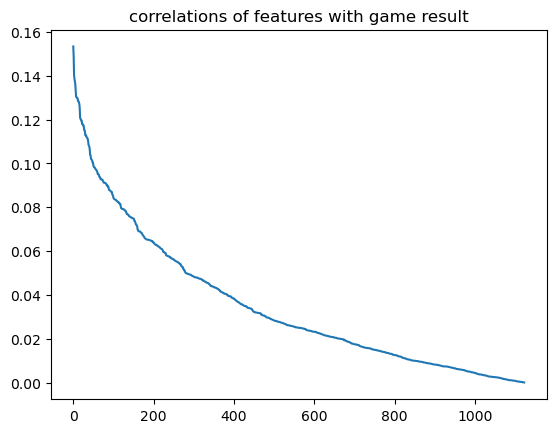

In [12]:
top_corr_home = get_correlation(train_home, train_labels)

plt.plot([i for i in range(len(top_corr_home))], top_corr_home)
plt.title('correlations of features with game result')
plt.show()

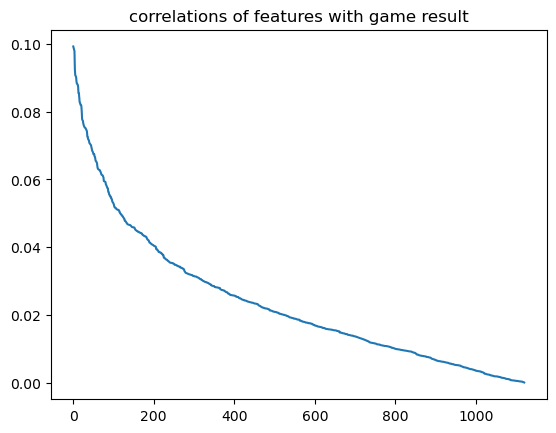

In [13]:
top_corr_away = get_correlation(train_away, train_labels)

plt.plot([i for i in range(len(top_corr_away))], top_corr_away)
plt.title('correlations of features with game result')
plt.show()

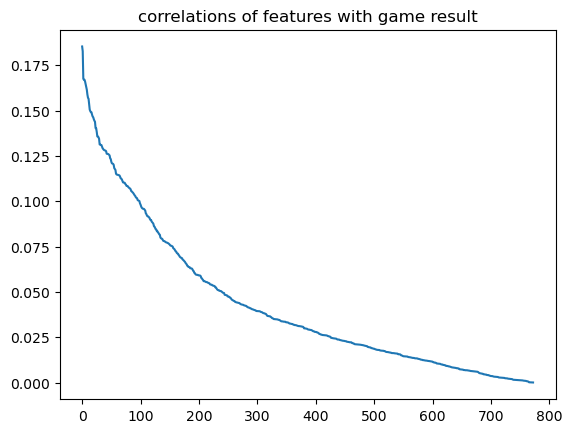

In [14]:
top_corr_diff_h_a = get_correlation(train_h_a, train_labels)

plt.plot([i for i in range(len(top_corr_diff_h_a))], top_corr_diff_h_a)
plt.title('correlations of features with game result')
plt.show()

In [15]:
bar = 0.14

In [16]:
top_corr_home = top_corr_home.loc[top_corr_home>bar].copy()
top_corr_away = top_corr_away.loc[top_corr_away>bar].copy()
top_corr_diff_h_a = top_corr_diff_h_a.loc[top_corr_diff_h_a>bar].copy()

ratio_home, ratio_home_corr = get_high_corr_ratio(train_home, train_labels, bar)
ratio_away, ratio_away_corr = get_high_corr_ratio(train_away, train_labels, bar)
ratio_h_a, ratio_h_a_corr = get_high_corr_ratio(train_h_a, train_labels, bar)

100%|████████████████████████████████████████████████████████████████████████| 596756/596756 [02:21<00:00, 4230.50it/s]


In [17]:
top_corr_home.index = 'Home_' + top_corr_home.index
top_corr_away.index = 'Away_' + top_corr_away.index
top_corr_diff_h_a.index = 'H_A_' + top_corr_diff_h_a.index
ratio_home_corr.index = 'Home_' + ratio_home_corr.index
ratio_away_corr.index = 'Away_' + ratio_away_corr.index
ratio_h_a_corr.index = 'H_A_' + ratio_h_a_corr.index

train_home.columns = 'Home_' + train_home.columns
train_away.columns = 'Away_' + train_away.columns
train_h_a.columns = 'H_A_' + train_h_a.columns
ratio_home.columns = 'Home_' + ratio_home.columns
ratio_away.columns = 'Away_' + ratio_away.columns
ratio_h_a.columns = 'H_A_' + ratio_h_a.columns

In [18]:
combine_corr = pd.concat([top_corr_home, top_corr_away, top_corr_diff_h_a, ratio_home_corr, ratio_away_corr, ratio_h_a_corr], axis=0)
combine_corr = abs(combine_corr)
combine_corr_sorted = combine_corr.sort_values(ascending=False)
# combine_corr_sorted.to_csv('combine_corr_sorted.csv')

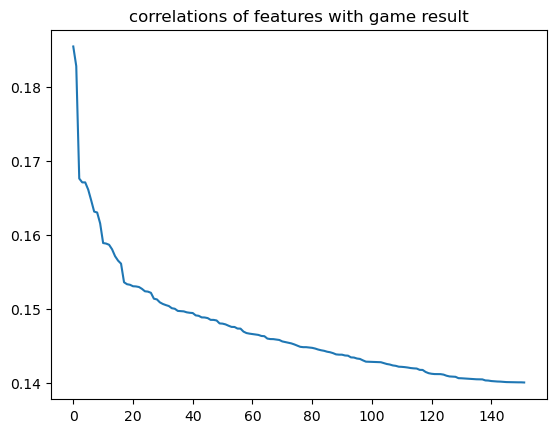

In [19]:
plt.plot([i for i in range(len(combine_corr_sorted))], combine_corr_sorted)
plt.title('correlations of features with game result')
plt.show()

In [20]:
# Remove duplicates of _average and _sum, get the highest score among them
def get_features_types(this_str):
    cleaned_string = this_str.replace('_sum', '').replace('_average', '')
    return cleaned_string


clean_features_corr = pd.DataFrame(combine_corr_sorted)
clean_features_corr['type'] = clean_features_corr.index.map(get_features_types)

idx = clean_features_corr.groupby('type')[0].idxmax()
highest_corr = clean_features_corr.loc[idx, [0]]
highest_corr = highest_corr.sort_values(by=0, ascending=False)

# get the features df
combine_features = pd.concat([train_home, train_away, train_h_a, ratio_home, ratio_away, ratio_h_a], axis=1)
selected_features = combine_features[highest_corr.index.tolist()]

In [21]:
selected_features

,H_A_TEAM_SHOTS_INSIDEBOX_season_average,H_A_TEAM_SHOTS_ON_TARGET_season_sum,H_A_TEAM_GAME_WON_season_average,H_A_TEAM_GOALS_season_sum,Home_TEAM_SHOTS_INSIDEBOX_season_average/attacker_mean_PLAYER_ACCURATE_PASSES_PERCENTAGE_season_std,H_A_TEAM_SHOTS_TOTAL_season_average,Home_TEAM_SHOTS_INSIDEBOX_season_average/goalkeeper_mean_PLAYER_GOALS_CONCEDED_season_std,Home_TEAM_SHOTS_TOTAL_season_average/attacker_mean_PLAYER_ACCURATE_PASSES_PERCENTAGE_season_std,H_A_TEAM_SHOTS_INSIDEBOX_5_last_match_sum,Home_TEAM_SHOTS_ON_TARGET_season_average/attacker_mean_PLAYER_ACCURATE_PASSES_PERCENTAGE_season_std,...,Home_TEAM_SHOTS_ON_TARGET_season_average/defender_mean_PLAYER_ACCURATE_PASSES_PERCENTAGE_season_std,Home_TEAM_SUCCESSFUL_PASSES_season_average/attacker_mean_PLAYER_GOALS_CONCEDED_season_std,H_A_TEAM_SHOTS_TOTAL_5_last_match_sum,H_A_TEAM_ATTACKS_season_average,Home_TEAM_SHOTS_TOTAL_season_average/defender_mean_PLAYER_GOALS_CONCEDED_season_std,Home_TEAM_PASSES_season_average/midfielder_mean_PLAYER_GOALS_CONCEDED_season_sum,Home_TEAM_SHOTS_INSIDEBOX_season_average/attacker_mean_PLAYER_ACCURATE_PASSES_PERCENTAGE_5_last_match_std,Home_TEAM_SHOTS_ON_TARGET_season_average/attacker_mean_PLAYER_GOALS_CONCEDED_season_average,Home_TEAM_PASSES_season_average/defender_mean_PLAYER_GOALS_CONCEDED_season_sum,Home_TEAM_SHOTS_ON_TARGET_season_average
ID,,,,,,,,,,,,,,,,,,,,,
0,1.0,1.0,-3.0,-1.0,NaN,-1.0,0.046512,NaN,1.0,NaN,...,0.066667,NaN,2.0,-3.0,0.068807,0.025210,NaN,NaN,0.026549,2.0
1,5.0,3.0,6.0,8.0,NaN,2.0,0.304348,NaN,4.0,NaN,...,0.425532,NaN,2.0,2.0,0.213675,0.094563,NaN,NaN,0.084175,5.0
2,-1.0,0.0,-1.0,-2.0,0.041958,0.0,0.037383,0.083916,-1.0,0.041958,...,0.072539,0.018750,-2.0,-1.0,0.073491,0.019802,0.050847,0.043716,0.016548,2.0
3,5.0,6.0,6.0,5.0,0.114943,7.0,0.135135,0.160920,-1.0,0.160920,...,0.388889,0.283465,-4.0,3.0,0.225806,0.293878,0.182927,0.321839,0.333333,7.0
4,-1.0,-3.0,-4.0,-4.0,0.092308,-2.0,0.096774,0.061538,-2.0,0.061538,...,0.068376,0.104348,-3.0,-2.0,0.072993,0.060694,0.109091,0.082474,0.070755,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12298,-5.0,-3.0,0.0,0.0,NaN,-3.0,0.060606,NaN,-5.0,NaN,...,0.245902,NaN,-5.0,3.0,0.119403,0.065116,NaN,NaN,0.056738,3.0
12299,0.0,0.0,0.0,0.0,0.044444,1.0,0.043478,0.088889,3.0,0.022222,...,0.025253,0.000000,5.0,-2.0,0.085837,0.000000,0.092308,0.048387,0.000000,1.0
12300,-4.0,-4.0,-4.0,-4.0,NaN,-3.0,0.076923,NaN,-3.0,NaN,...,0.088757,NaN,-3.0,-5.0,0.063604,0.000000,NaN,NaN,0.000000,3.0


### train, valid test split

In [22]:
# train_new_y = train_scores['AWAY_WINS']

# train_labels
X_train, X_test, y_train, y_test = model_selection.train_test_split(selected_features, train_labels, train_size=0.8, random_state=42)
X_train_1, X_valid, y_train_1, y_valid = model_selection.train_test_split(X_train, y_train, train_size=0.8, random_state=42)

### xgb model

In [23]:
params_1 = {
        'objective': 'multi:softprob',
        'num_class': 3,
        'eval_metric': 'mlogloss',
        'max_depth': 8,
        'min_child_weight': 0.5,
        'subsample': 0.5,
        'colsample_bytree': 0.5,
        'learning_rate': 0.025,
    }

model = xgb.XGBClassifier(**params_1, random_state = 42)
model.fit(X_train, y_train)
print(accuracy_score(model.predict(X_test), y_test))

0.4904510361641609


In [24]:
def xgboost_hyperpara_tuning(trial):

    params_1 = {
        'objective': 'multi:softprob',
        'n_estimators': trial.suggest_int('n_estimators', 50,500),
        'num_class': 3,
        'eval_metric': 'mlogloss',
        'booster': trial.suggest_categorical('booster', ['gbtree']),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.1, 3),
        'subsample': trial.suggest_float('subsample', 0.4, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.007, 0.06),
    }

    model = xgb.XGBClassifier(**params_1, random_state = 42)
    
    # 5 fold cross validation
    accuracy = cross_val_score(model, X_train, y_train, cv=5, scoring=make_scorer(accuracy_score)).mean()

    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(xgboost_hyperpara_tuning, n_trials=50)

[I 2024-06-20 16:15:11,331] A new study created in memory with name: no-name-a19c695d-47ba-4505-b374-0e4bf80248d7
[I 2024-06-20 16:16:28,046] Trial 0 finished with value: 0.487094992712243 and parameters: {'n_estimators': 467, 'booster': 'gbtree', 'max_depth': 6, 'min_child_weight': 1.8003485952664757, 'subsample': 0.8199507015108699, 'colsample_bytree': 0.5302631560544933, 'learning_rate': 0.017611814494951125}. Best is trial 0 with value: 0.487094992712243.
[I 2024-06-20 16:16:56,065] Trial 1 finished with value: 0.49146439528133223 and parameters: {'n_estimators': 115, 'booster': 'gbtree', 'max_depth': 6, 'min_child_weight': 0.8576885110079442, 'subsample': 0.6586302973455124, 'colsample_bytree': 0.7305514640730191, 'learning_rate': 0.020100170667176086}. Best is trial 1 with value: 0.49146439528133223.
[I 2024-06-20 16:17:42,706] Trial 2 finished with value: 0.4889250352000727 and parameters: {'n_estimators': 259, 'booster': 'gbtree', 'max_depth': 6, 'min_child_weight': 0.264793650

[I 2024-06-20 16:34:41,727] Trial 23 finished with value: 0.4927858947837828 and parameters: {'n_estimators': 82, 'booster': 'gbtree', 'max_depth': 3, 'min_child_weight': 1.9017239052208679, 'subsample': 0.7757017123056535, 'colsample_bytree': 0.7281811983741607, 'learning_rate': 0.021117486841677108}. Best is trial 14 with value: 0.4940045811707482.
[I 2024-06-20 16:34:59,317] Trial 24 finished with value: 0.492887727252082 and parameters: {'n_estimators': 165, 'booster': 'gbtree', 'max_depth': 4, 'min_child_weight': 2.3308223755375663, 'subsample': 0.5933900854943281, 'colsample_bytree': 0.8099755471444793, 'learning_rate': 0.011364890476255086}. Best is trial 14 with value: 0.4940045811707482.
[I 2024-06-20 16:35:16,810] Trial 25 finished with value: 0.49420819449433695 and parameters: {'n_estimators': 107, 'booster': 'gbtree', 'max_depth': 5, 'min_child_weight': 1.4817418308938424, 'subsample': 0.5081207047645184, 'colsample_bytree': 0.7051602740811738, 'learning_rate': 0.017865009

[I 2024-06-20 16:43:09,838] Trial 47 finished with value: 0.4907539422016871 and parameters: {'n_estimators': 64, 'booster': 'gbtree', 'max_depth': 6, 'min_child_weight': 2.6036661311157983, 'subsample': 0.5603664917918821, 'colsample_bytree': 0.8581709915808194, 'learning_rate': 0.009231088059102683}. Best is trial 25 with value: 0.49420819449433695.
[I 2024-06-20 16:43:21,910] Trial 48 finished with value: 0.49258295242932115 and parameters: {'n_estimators': 139, 'booster': 'gbtree', 'max_depth': 3, 'min_child_weight': 2.821791946090419, 'subsample': 0.46635484144749456, 'colsample_bytree': 0.8871073733433004, 'learning_rate': 0.028714332977224113}. Best is trial 25 with value: 0.49420819449433695.
[I 2024-06-20 16:43:42,300] Trial 49 finished with value: 0.49237933910573234 and parameters: {'n_estimators': 173, 'booster': 'gbtree', 'max_depth': 4, 'min_child_weight': 2.0501185694089124, 'subsample': 0.736403749772278, 'colsample_bytree': 0.6995851127214763, 'learning_rate': 0.019230

In [25]:
best_params_pca = study.best_params
print("Best params:", best_params_pca)

best_xgb_model = xgb.XGBClassifier(**best_params_pca, random_state = 42)
best_xgb_model.fit(X_train, y_train)

Best params: {'n_estimators': 107, 'booster': 'gbtree', 'max_depth': 5, 'min_child_weight': 1.4817418308938424, 'subsample': 0.5081207047645184, 'colsample_bytree': 0.7051602740811738, 'learning_rate': 0.017865009833922585}


XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7051602740811738, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.017865009833922585,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1.4817418308938424, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=107,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

### Some analysis

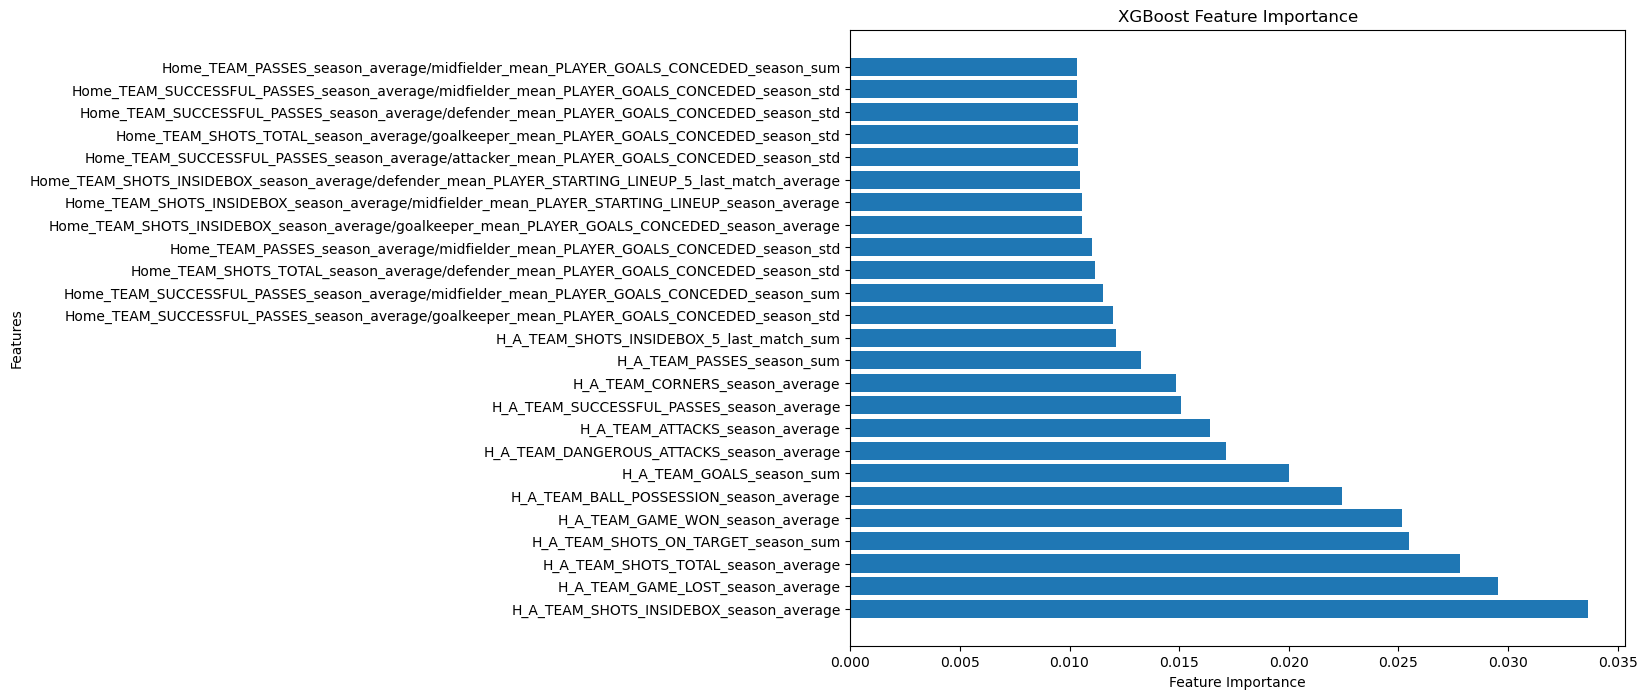

In [26]:
feature_importances = best_xgb_model.feature_importances_
sorted_idx = np.argsort(feature_importances)[::-1][:25]  # 获取前25个最重要的特征的索引
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), selected_features.columns[sorted_idx])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('XGBoost Feature Importance')
plt.show()

### Accuracy on test set

Using our model

In [27]:
predictions = best_xgb_model.predict(X_test)
print(accuracy_score(predictions, y_test))

0.4880130028443722


## Submission

In [28]:
test_home = pd.read_csv('./Test_Data/test_home_team_statistics_df.csv', index_col=0)
test_away = pd.read_csv('./Test_Data/test_away_team_statistics_df.csv', index_col=0)

test_home_player_statistics_df = pd.read_csv('./Test_Data/test_home_player_statistics_df.csv', index_col=0)
test_away_player_statistics_df = pd.read_csv('./Test_Data/test_away_player_statistics_df.csv', index_col=0)

In [29]:
test_home = clean_nan_zero_columns(test_home, 0.5)
test_away = clean_nan_zero_columns(test_away, 0.5)

test_h_a = test_home - test_away
test_h_a = clean_nan_zero_columns(test_h_a, 0.5)

test_home_player = test_home_player_statistics_df.loc[~test_home_player_statistics_df['POSITION'].isna()]
test_home_player_feature = pd.DataFrame()
test_away_player = test_away_player_statistics_df.loc[~test_away_player_statistics_df['POSITION'].isna()]
test_away_player_feature = pd.DataFrame()

positions = ['midfielder', 'defender', 'attacker', 'goalkeeper']

for position in positions:
    tmp_df = get_formation_features(test_home_player, position)
    test_home_player_feature = pd.concat([test_home_player_feature, tmp_df], axis=1)
    tmp_df = get_formation_features(test_away_player, position)
    test_away_player_feature = pd.concat([test_away_player_feature, tmp_df], axis=1)

formation_df = test_home_player.groupby(test_home_player.index)['POSITION'].value_counts().unstack(fill_value=0)    # formation of the team
test_home = pd.concat([test_home, formation_df, test_home_player_feature], axis=1)

formation_df = test_away_player.groupby(test_away_player.index)['POSITION'].value_counts().unstack(fill_value=0)
test_away = pd.concat([test_away, formation_df, test_away_player_feature], axis=1)

test_home.columns = 'Home_' + test_home.columns
test_away.columns = 'Away_' + test_away.columns
test_h_a.columns = 'H_A_' + test_h_a.columns

combine_features_test = pd.concat([test_home, test_away, test_h_a], axis=1)
selected_features_test = pd.DataFrame()

for this_column in selected_features.columns:
    if 'Home_' in this_column:
        if '/' in this_column:
            column_name = this_column.split('/')
            selected_features_test[this_column] = test_home[column_name[0]] / test_home['Home_' + column_name[1]]
        else:
            selected_features_test[this_column] = test_home[this_column]        
    elif 'Away_' in this_column:
        if '/' in this_column:
            column_name = this_column.split('/')
            selected_features_test[this_column] = test_away[column_name[0]] / test_away['Away_' + column_name[1]]
        else:
            selected_features_test[this_column] = test_away[this_column]
    elif 'H_A_' in this_column:
        if '/' in this_column:
            column_name = this_column.split('/')
            selected_features_test[this_column] = test_h_a[column_name[0]] / test_h_a['H_A_' + column_name[1]]
        else:
            selected_features_test[this_column] = test_h_a[this_column]
    else:
        raise ValueError("Exception Column Name")

selected_features_test
# combine_features


,H_A_TEAM_SHOTS_INSIDEBOX_season_average,H_A_TEAM_SHOTS_ON_TARGET_season_sum,H_A_TEAM_GAME_WON_season_average,H_A_TEAM_GOALS_season_sum,Home_TEAM_SHOTS_INSIDEBOX_season_average/attacker_mean_PLAYER_ACCURATE_PASSES_PERCENTAGE_season_std,H_A_TEAM_SHOTS_TOTAL_season_average,Home_TEAM_SHOTS_INSIDEBOX_season_average/goalkeeper_mean_PLAYER_GOALS_CONCEDED_season_std,Home_TEAM_SHOTS_TOTAL_season_average/attacker_mean_PLAYER_ACCURATE_PASSES_PERCENTAGE_season_std,H_A_TEAM_SHOTS_INSIDEBOX_5_last_match_sum,Home_TEAM_SHOTS_ON_TARGET_season_average/attacker_mean_PLAYER_ACCURATE_PASSES_PERCENTAGE_season_std,...,Home_TEAM_SHOTS_ON_TARGET_season_average/defender_mean_PLAYER_ACCURATE_PASSES_PERCENTAGE_season_std,Home_TEAM_SUCCESSFUL_PASSES_season_average/attacker_mean_PLAYER_GOALS_CONCEDED_season_std,H_A_TEAM_SHOTS_TOTAL_5_last_match_sum,H_A_TEAM_ATTACKS_season_average,Home_TEAM_SHOTS_TOTAL_season_average/defender_mean_PLAYER_GOALS_CONCEDED_season_std,Home_TEAM_PASSES_season_average/midfielder_mean_PLAYER_GOALS_CONCEDED_season_sum,Home_TEAM_SHOTS_INSIDEBOX_season_average/attacker_mean_PLAYER_ACCURATE_PASSES_PERCENTAGE_5_last_match_std,Home_TEAM_SHOTS_ON_TARGET_season_average/attacker_mean_PLAYER_GOALS_CONCEDED_season_average,Home_TEAM_PASSES_season_average/defender_mean_PLAYER_GOALS_CONCEDED_season_sum,Home_TEAM_SHOTS_ON_TARGET_season_average
ID,,,,,,,,,,,,,,,,,,,,,
12303,-1.0,-6.0,-2.0,-3.0,0.119048,-4.0,0.120482,0.047619,1.0,0.000000,...,0.000000,0.185567,0.0,0.0,0.048780,0.099849,0.238095,0.000000,0.084706,0.0
12304,-2.0,-2.0,-4.0,-5.0,0.062500,-1.0,0.076923,0.093750,0.0,0.062500,...,0.063158,0.037037,2.0,-2.0,0.097297,0.035176,0.075949,0.085714,0.024590,2.0
12305,10.0,6.0,5.0,7.0,0.224719,7.0,0.227273,0.157303,4.0,0.179775,...,0.258065,0.111888,2.0,2.0,0.167665,0.108108,0.394737,0.336842,0.098765,8.0
12306,-4.0,0.0,2.0,1.0,NaN,-3.0,0.160000,NaN,-3.0,NaN,...,0.428571,NaN,-3.0,-7.0,0.084112,0.121387,NaN,NaN,0.140078,8.0
12307,0.0,-1.0,1.0,3.0,0.063380,0.0,0.067416,0.063380,-3.0,0.042254,...,0.067961,0.000000,-2.0,0.0,0.058989,0.000000,0.098901,0.056738,0.000000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37666,-6.0,-5.0,-3.0,-3.0,NaN,-4.0,0.085714,NaN,-5.0,NaN,...,NaN,NaN,-6.0,-2.0,0.126582,0.042254,NaN,NaN,0.028090,4.0
37667,1.0,-1.0,-1.0,-4.0,NaN,-2.0,0.080000,NaN,-1.0,NaN,...,NaN,NaN,-3.0,6.0,0.083086,0.130435,NaN,NaN,0.129630,7.0
37668,7.0,5.0,3.0,4.0,0.227273,8.0,0.196078,0.227273,3.0,0.159091,...,0.214724,0.164835,4.0,1.0,0.223881,0.147679,0.303030,0.500000,0.130435,7.0


In [30]:
predictions = best_xgb_model.predict(selected_features_test)

predictions_df = pd.DataFrame(predictions, columns=['predict'])
predictions_df['HOME_WINS'] = 0
predictions_df['DRAW'] = 0
predictions_df['AWAY_WINS'] = 0
predictions_df.loc[predictions_df['predict']==2, 'HOME_WINS'] = 1
predictions_df.loc[predictions_df['predict']==1, 'AWAY_WINS'] = 1
predictions_df.loc[predictions_df['predict']==0, 'DRAW'] = 1
submission = predictions_df[['HOME_WINS', 'DRAW', 'AWAY_WINS']]
submission.index = selected_features_test.index

submission.to_csv('./benchmark_submission.csv', index=False)
submission


,HOME_WINS,DRAW,AWAY_WINS
ID,,,
12303,1,0,0
12304,0,0,1
12305,1,0,0
12306,1,0,0
12307,0,0,1
...,...,...,...
37666,0,0,1
37667,1,0,0
37668,1,0,0
